In [12]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# Introduction to Hypothesis Testing

## Statistics vs. Probability


Probability is the study of how (abstract) random variables and distributions behave.  Statistics is the study of how to interpret data while making assumptions about the underlying distributions.  Probability is a rigorous branch of mathematics, involving precise theorems and proofs.  (Applied) statistics is a much more squishy subject that requires imperfect assumptions about real-world phenomena. It is therefore more subject to errors in human judgment and argumentation.

In [13]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pylab as plt

def plot_hist_dist(rvs, dist, title=None, label='', mean=None, confidence_interval=None, ax=None):
    ax = ax if ax else plt.gca()
    _, bins, _ = ax.hist(rvs, bins=50, alpha=.6, label=(label + ' rvs').strip(), color='blue')
    xmin, xmax = bins.min(), bins.max()
    xpoints = np.arange(xmin, xmax, (xmax - xmin) / 100)
    ax.plot(xpoints, dist.pdf(xpoints), label=(label+' pdf').strip(), color='black')
    
    if mean is not None:
        ax.plot([mean, mean], plt.ylim(), label='mean', color='purple')

    if confidence_interval:
        ymid = np.sum(plt.ylim()) / 2.
        plt.text(mean, ymid, 'CI', ha='center', va='bottom')
        plt.annotate("", xy=(confidence_interval[0], ymid), xycoords='data',
                     xytext=(confidence_interval[1], ymid), textcoords='data',
                     arrowprops=dict(arrowstyle="|-|", lw=2, color='r'))    

    if title:
        ax.set_title(title)

    ax.legend()
    
def plot_hist_dist_discrete(rvs, dist, title=None, label='', ax=None):
    ax = ax if ax else plt.gca()
    uniques = np.unique(rvs)
    mids = (uniques[1:] + uniques[:-1]) / 2.
    bins = np.hstack([[uniques[0]-.5], mids, [uniques[-1] + .5]])
    plt.hist(rvs, bins=bins, label=(label + ' rvs').strip(), alpha=.6, color='blue')
    if title:
        ax.set_title(title)
    plt.plot(uniques, dist.pmf(uniques), label=(label + ' pmf').strip(), color='black')
    ax.legend()

## Statistical Inference


The most common applications of statistics are to estimate parameters that describe a population, process, or phenomenon under some model and to test hypotheses (usually about whether a model or model parameters accurately describe a population, process, or phenomenon).

Examples of parameter estimation are:
- Estimating the mean income of American construction workers
- Estimating the variance in daily energy consumption during a summer in New York City
- Estimating the correlation coefficient between height and average points per game for power forwards in the NBA

Examples of hypothesis testing are:
- Testing if there is a significant difference between the mean income of unionized and non-union construction workers
- Testing if the variance in energy consumption is significantly larger than the surge capacity of the electrical grid can accommodate
- Testing if the correlation coefficient between height and points per NBA game is significantly different from zero

Let's examine the example of income of union and non-union construction workers in more depth.

## Estimating Mean


The first step in testing whether the mean income of unionized and non-union workers is significantly different is to make measurements. In statistics we call a collection of measurements a **sample**. There are many sampling methods and collecting an unbiased and representative sample is often a difficult task. Sampling theory is beyond the scope of this lecture.

Let's say you have a sample of data (e.g. individual unionized worker incomes) $X_1, \ldots, X_n$.  We estimate the population mean, $\mu$, as

$$ \overline X = \frac{1}{n} \sum_{k=1}^n X_k. $$

This is implemented by the function `np.mean()` or the `.mean()` method of a NumPy array.

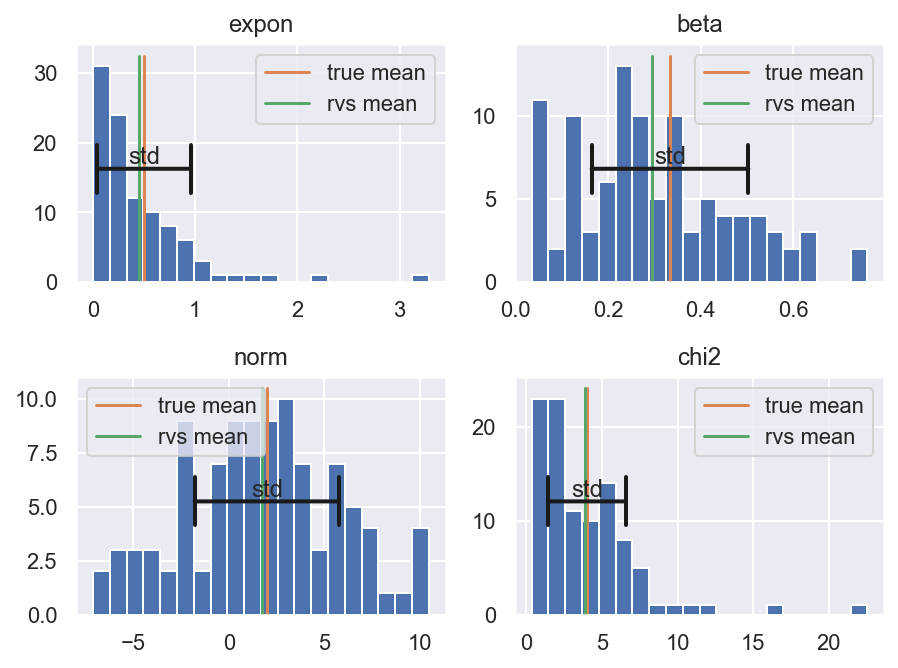

In [14]:
def plot_empirical_dist(dist, size=100):
    X = dist.rvs(size=size)
    mean, var = dist.stats('mv')
    rvs_mean = X.mean()

    plt.hist(X, bins=20)
    ymin, ymax = plt.ylim()
    ymid = (ymin + ymax) / 2.
    plt.plot([mean]*2, [ymin, ymax], label='true mean')
    plt.plot([rvs_mean]*2, [ymin, ymax], label='rvs mean')
    plt.text(mean, ymid, 'std', ha='center', va='bottom')
    plt.annotate("", xy=(mean-np.sqrt(var), ymid), xycoords='data',
                 xytext=(mean+np.sqrt(var), ymid), textcoords='data',
                 arrowprops=dict(arrowstyle="|-|", connectionstyle="arc3", lw=2, color='k'))
    plt.title(dist.dist.name)
    plt.legend()
    
dists = (
    sp.stats.expon(scale=1/2.),
    sp.stats.beta(a=2., b=4.),
    sp.stats.norm(loc=2., scale=4.),
    sp.stats.chi2(df=4.)
)

for k, dist in enumerate(dists):
    plt.subplot(2,2,k+1)
    plot_empirical_dist(dist)
plt.tight_layout()

Let's create a probability distribution that we can use to generate samples of incomes for union construction workers.

(10.0, 100.0)

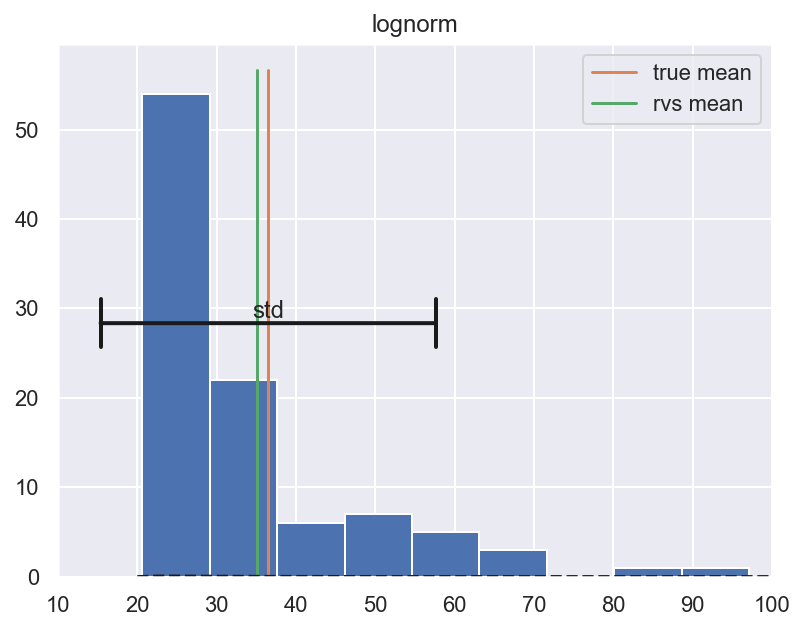

In [15]:
union_incomes = sp.stats.lognorm(1, loc=20, scale=10)
plot_empirical_dist(union_incomes, size=100)
plt.plot(np.arange(20, 100, .01), union_incomes.pdf(np.arange(20, 100, .01)), 'k--')
plt.xlim([10, 100])

## Standard Error of Mean


If we run the example code for estimating the mean, we will get different samples and different sample means.

As we have seen, an estimate is noisy and is not always equal to its expected value.  What is the uncertainty of our sample mean?  More appropriately, what is the standard deviation of the sampling distribution of the sample mean given our sample size $n$?

Let's take our mean estimator $\overline X$ for the sample $X_1, \ldots, X_n$.  The Central Limit Theorem tells us that as $n$ increases, our estimate of $\overline X$ starts to look like the normal distribution:

$$ \overline X \sim N\left(\mu, \frac{\sigma^2}{n} \right) $$

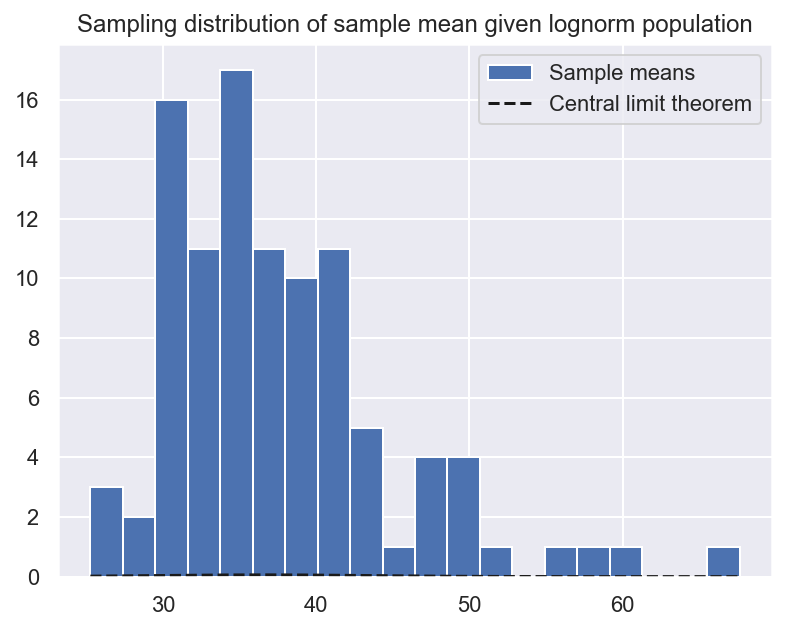

In [16]:
def plot_sample_mean_dist(dist, sample_size, n_samples=100):
    sample_means = [dist.rvs(size=sample_size).mean() for i in range(n_samples)]
    mean, var = dist.stats('mv')
    
    plt.hist(sample_means, bins=20, label='Sample means')
    ymin, ymax = plt.ylim()
    ymid = (ymin + ymax) / 2.
    plt.plot(np.linspace(min(sample_means), 
                         max(sample_means), 1000), 
             sp.stats.norm.pdf(np.linspace(min(sample_means), 
                                           max(sample_means), 1000), 
                               loc=mean, scale=np.sqrt(var/sample_size)), 'k--',
            label = 'Central limit theorem')
    plt.title("Sampling distribution of sample mean given {} population".format(dist.dist.name))
    plt.legend()
    
plot_sample_mean_dist(union_incomes, 10)

The standard deviation of the sampling distribution of the sample mean (i.e. the normal distribution given by the Central Limit Theorem) is called the **standard error** or **standard error of the sample mean**. As we can see from the result of the Central Limit Theorem

$$ s_{\overline X} = \sqrt{\frac{\sigma^2}{n}} $$

Given an observation and an underlying distribution, the **z-score** measures the number of standard deviations the observation is above the mean.  For the case of the the observation $\overline X$, we expect the z-score
$$ z = \frac{\overline X - \mu}{\sigma / \sqrt{n}} $$
to be distributed as a standard normal (with mean zero and standard deviation one).

**Gotchas:**
- Standard deviation ($\sigma$ in our case) is not standard error ($\sigma/\sqrt{n}$)!  Don't confuse the two.
- What is the difference between the standard deviation and the standard error?

In [17]:
_, var = union_incomes.stats()
n=100
sampling_hist_std = np.std([union_incomes.rvs(size=n).mean() for i in range(1000)])

print ("Standard error in central limit theorem: {}".format(np.sqrt(var / n)))
print ("Standard error estimated from repeated sampling: {}".format(sampling_hist_std))

Standard error in central limit theorem: 2.1611974158950877
Standard error estimated from repeated sampling: 2.204653174000204


## Hypothesis Testing


Perhaps we think unionized workers are paid more than their non-union counterparts. We can test this hypothesis in the following conventional framework:

1. **Define a null hypothesis, $H_0$.** The null hypothesis is what we assume to be true at the outset. For example, we might naively believe that unions don't affect construction worker pay. If we know that non-union workers make on average \$32K/yr, then our null hypothesis is that union construction workers mean income is \$32K/yr. Formally, $H_0$ is $\mu=32$.
  
2. **Define an alternative hypothesis, $H_a$ or $H_1$.** The alternative hypothesis is a particular negation of the null hypothesis. In this case, the possibilities are $\mu > 32$, $\mu < 32$, or $\mu \ne 32$. Because we think unionized workers are paid more than non-union workers, we will choose $\mu > 32$.

3. **Choose a threshold of significance, $\alpha$.** Assuming that the null hypothesis is true, we should be unlikely to observe samples with mean incomes much higher than \$32K/yr. The significance level is a probability threshold at which we decide that we could not have observed such a large deviation from the null hypothesis by random chance alone, and that therefore the null hypothesis is false. We'll choose $\alpha = 0.05$. This is a conventional, _though totally arbitrary_, choice. You should choose an $\alpha$ based on your _tolerance for error_.

We've established that for a sufficiently large sample, the mean income of a sample of union workers is itself a normally distributed random variable with a mean equal to $\mu$ and variance equal to the square of the standard error. Therefore we can calculate the probability of observing a particular sample mean _or larger_

$$ \mathbb{P}(\overline X \ge \overline x) = 1 - \int_{-\infty}^{\overline x} n(y \mid \mu, \frac{\sigma^2}{n})dy = 1 - N\left(\frac{\overline x - \mu}{\sigma/\sqrt{n}}\right)$$

or equivalently

$$ \int_{-\infty}^{z} n(x \mid 0, 1)dx = N(z) $$

**Question:** How would we calculate the probability of observing a particular sample mean _or less_?

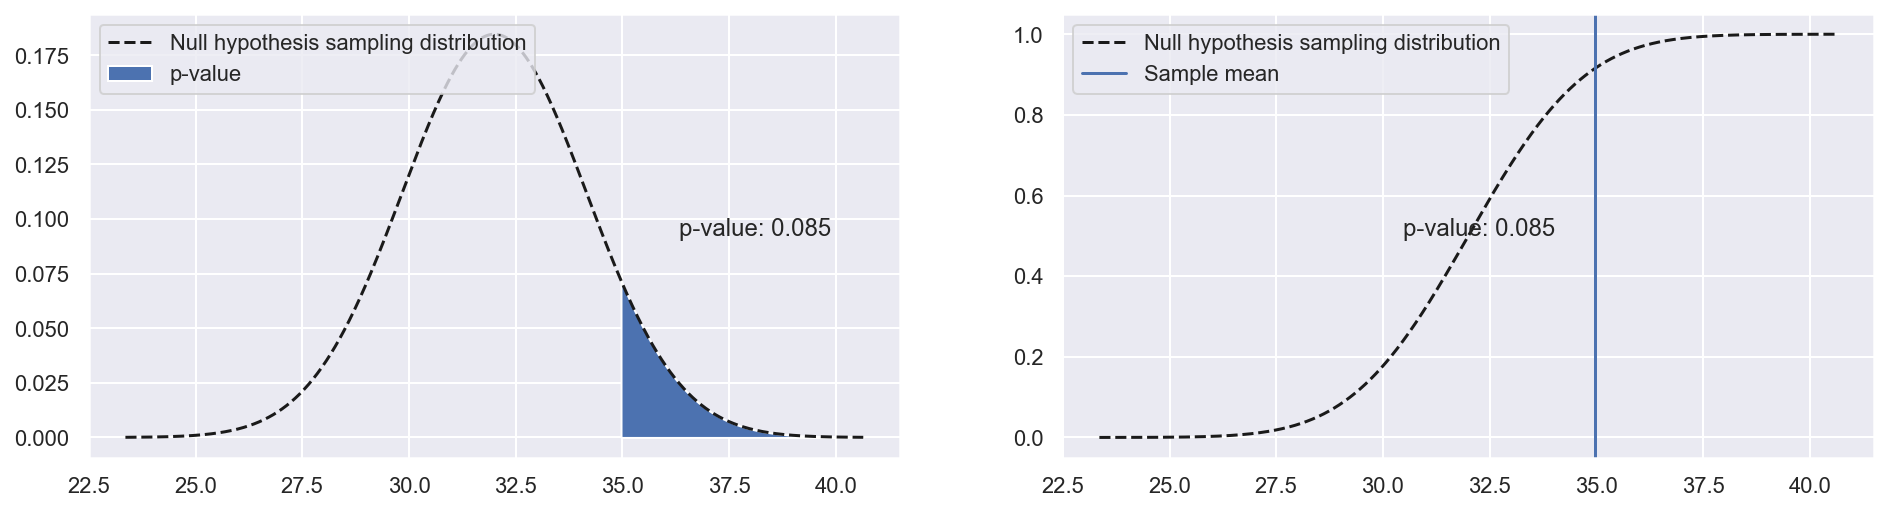

In [18]:
_, var = union_incomes.stats()
h0 = 32

n=100
sample_mean = union_incomes.rvs(n).mean()
x = np.linspace(h0 - 4 * np.sqrt(var / n), h0 + 4 * np.sqrt(var / n), 1000)
clt = sp.stats.norm(loc=h0, scale=np.sqrt(var / n))

plt.figure(figsize=[16, 4])

plt.subplot(121)
plt.plot(x, clt.pdf(x), 'k--', label = 'Null hypothesis sampling distribution')
plt.fill_between(x[x>sample_mean], 0, clt.pdf(x)[x>sample_mean], label = 'p-value')
plt.text(x[-250], clt.pdf(x).max() / 2, 'p-value: {:.3}'.format(1 - clt.cdf(sample_mean)))
plt.legend(loc=2)

plt.subplot(122)
plt.plot(x, clt.cdf(x), 'k--', label = 'Null hypothesis sampling distribution')
plt.axvline(sample_mean, label='Sample mean')
plt.text(sample_mean-4.5, .5, 'p-value: {:.3}'.format(1 - clt.cdf(sample_mean)))
plt.legend(loc=2)

The probability of observing $\overline X$ *or a result that is more extreme* is called the **p-value**.  When we observe a sample with a p-value less than $\alpha$, we take it as evidence to reject the null hypothesis.  What does more extreme mean?  Here are two common definitions:
1. **One sided test:** If we are testing whether $\overline X$ is statistically significantly greater than $\mu$, the p-value would be given by
$$1-N\left(\overline X \mid \mu, \sigma^2\right) = 1-N\left(z \mid 0, 1\right)$$
where $N(x \mid \mu,\sigma^2)$ is the normal CDF with mean $\mu$ and standard deviation $\sigma$.  If we are testing whether $\overline X$ is statistically significantly less than zero, the p-value would be $N\left(\overline X \mid \mu, \sigma^2\right)$.  As usual, we will probably use $\sigma = \hat \sigma$, the estimated standard deviation.
1. **Two sided test:** We are testing whether $\overline X$ is different (either greater or smaller) than $\mu$ and if this is statistically significant.  The $p$-value is given by $2 \cdot N\left(-\left|\overline X\right|  \mid  \mu, \sigma^2\right)$.

## Confidence Intervals and Probabilities


We may decide to reject the null hypothesis, $H_0: \mu=32$. In that case, what is $\mu$? Our alternative hypothesis doesn't say!

We define the $z$-$\sigma$ **confidence interval** or $z$-standard-deviation **confidence interval** (where $z \ge 0$) to be the interval
$$ [\overline X - zs, \overline X + zs] \,.$$

If we assume the mean estimate is normally distributed (due to the Central Limit Theorem), then we can use the statistics of the normal distribution to compute the probability that the mean estimate falls within the $z$-$\sigma$ confidence interval.  If $n(x\mid\mu,\sigma)$ is the normal PDF with mean $\mu$ and standard deviation $\sigma$, then the probability that the mean falls within the $z$-$\sigma$ confidence interval is

$$ \int_{\overline X - zs}^{\overline X + zs} n(x \mid \overline X, s)dx = \int_{- z}^{z} n(x \mid 0, 1)dx = N(z) - N(-z) $$
where $N$ is the cumulative normal distribution.  We usually choose $z$ to be 2 (~95% confidence interval) or 3 (~99% confidence interval).

Text(0, 0.5, 'probability captured in CI')

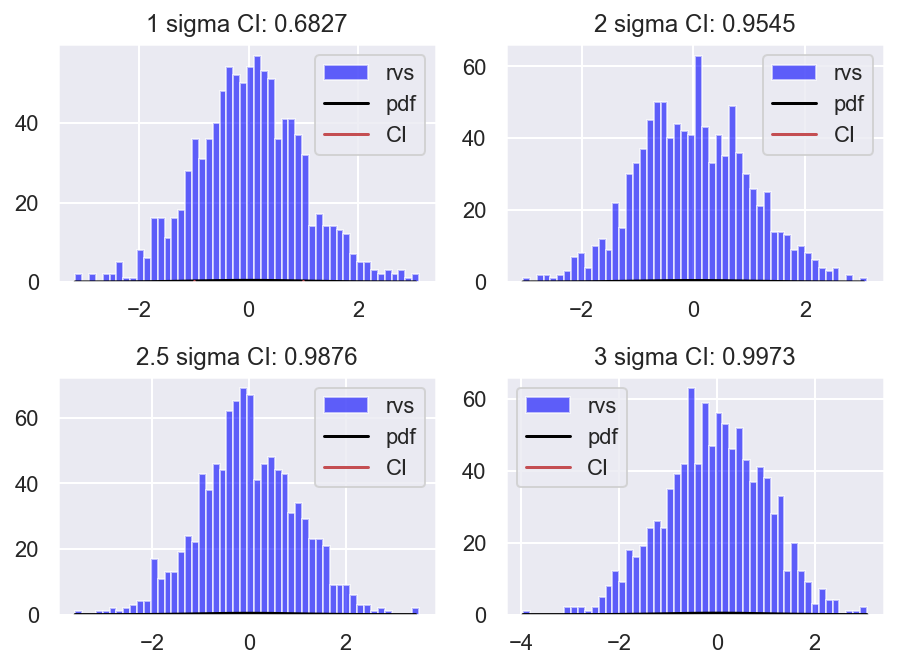

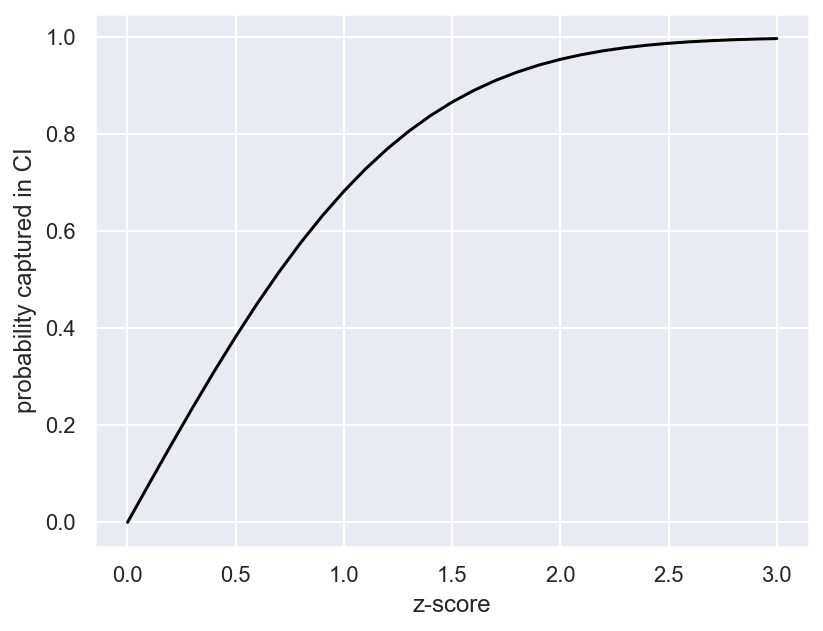

In [19]:
# Confidence intervals at various rates

N = 1000

norm = sp.stats.norm()

zs = (1, 2, 2.5, 3)

for k, z in enumerate(zs):
    plt.subplot(2,2,k+1)
    plot_hist_dist(norm.rvs(size=N), norm)
    plt.plot([-z, -z], [0, norm.pdf(-z)], 'r', label='CI')
    plt.plot([z, z], [0, norm.pdf(z)], 'r')
    prob = norm.cdf(z) - norm.cdf(-z)
    plt.title('{} sigma CI: {:.4f}'.format(z, prob))
    plt.legend()

plt.tight_layout()

plt.figure()
z=np.arange(0, 3., .1-1e-9)
plt.plot(z, norm.cdf(z) - norm.cdf(-z), color='black')
plt.xlabel('z-score')
plt.ylabel('probability captured in CI')

## Hypothesis Testing Two Means


In our hypothesis testing example, we are interested in whether unionized construction workers make more money than their non-union counterparts. We assert a null hypothesis that they do not, and therefore union workers share the average income of non-union workers: \$32K/yr. Where did this number come from? We "magically" knew it (i.e. we chose it for the example). Sometimes this will be the case -- previous studies will have established good estimates of population parameters that we can then safely assume to be accurate. However, more often we will need to sample both populations that we are comparing. 

We may collect a sample of incomes, $X_1, \ldots, X_m$, from union workers and calculate its mean, $\overline X$, and a sample of incomes from non-union workers, $Y_1, \ldots, Y_n$, and calculate its mean, $\overline Y$.  From above, we know that

$$ \overline X \longrightarrow N\left(\mu_X, \frac{\sigma^2_X}{m} \right) \qquad \overline Y \longrightarrow N\left(\mu_Y, \frac{\sigma^2_Y}{n} \right)\,. $$

Because we know that the sum of two normal distributions is also normal, we know that

$$ \overline X - \overline Y \longrightarrow N\left(\mu_X - \mu_Y, \frac{\sigma^2_X}{m} + \frac{\sigma^2_Y}{n} \right)\,. $$

We can use the above to compute a z-score for the difference $\overline X - \overline Y$.

In this framework we would revise our null hypothesis 

$$ H_0: \mu=32 \Rightarrow H_0: \mu_x - \mu_y = 0 $$ 

**Questions:**
1. How do we hypothesis test if $\overline X > \overline Y$ for a specific p-value?
1. How do the formulas change if we model the underlying variables $X$ and $Y$ as Bernoulli trials?

## Estimating Variance


Let's say you have a collection of data $X_1, \ldots, X_n$.  To estimate the variance, one might think the right answer is

$$ \frac{1}{n} \sum_{k=1}^n (X_k - \overline X)^2 $$

where $\overline{X}$ is the mean estimator or the *empirical mean*.  This turns out to be **biased**.  That is, the answer is expected to be smaller than the true variance.  Mathematically, if we let $\mu$ be the true mean and $\sigma^2$ be the true variance, then
$$
\begin{align}
    \mathbb{E}\left[ \frac{1}{n}\sum_{k=1}^n \left(X_k-\overline{X}\right)^2 \right]
    &= \mathbb{E}\bigg[ \frac{1}{n}\sum_{k=1}^n \big((X_k-\mu)-(\overline{X}-\mu)\big)^2 \bigg] \\[4pt]
    &= \mathbb{E}\bigg[ \frac{1}{n}\sum_{k=1}^n (X_k-\mu)^2 -
                              2(\overline{X}-\mu)(X_k-\mu) +
                              (\overline{X}-\mu)^2 \bigg] \\[4pt]
    &= \mathbb{E}\bigg[ \frac{1}{n}\sum_{k=1}^n (X_k-\mu)^2 - (\overline{X}-\mu)^2 \bigg] \\[4pt]
    &= \sigma^2 - \mathbb{E}\left[ \left(\overline{X}-\mu\right)^2 \right] \\
    &< \sigma^2\,
\end{align}
$$

Mathematically, we can see that
$$
\begin{align}
    \mathbb{E}\left[ \left(\overline{X}-\mu\right)^2 \right]
    &= \mathbb{E}\left[ \left(\frac{1}{n}\sum_{k=1}^n (X_k-\mu)\right)^2 \right] \\[4pt]
    &= \frac{1}{n^2} \sum_{k=1}^n \mathbb{E}\left[ \left(X_k-\mu\right)^2 \right] \\
    &= \frac{\sigma^2}{n}
\end{align}\,
$$
Combining this with the above, we see that 
$$
\begin{align}
    \frac{1}{n-1} \mathbb{E}\left[ \sum_{k=1}^n \left(X_k-\overline{X}\right)^2 \right]
    &= \frac{n}{n-1} \cdot \mathbb{E}\left[ \frac{1}{n} \sum_{k=1}^n \left(X_k-\overline{X}\right)^2 \right] \\[4pt]
    &= \frac{n}{n-1} \cdot \sigma^2 \cdot \left( 1 - \frac{1}{n} \right) \\[4pt]
    &= \sigma^2 \,
\end{align}
$$

Therefore, the **unbiased estimator** of the variance is
$$ \hat\sigma^2 = \frac{1}{n-1} \sum_{k=1}^n (X_k - \overline X)^2\, $$

Both are implemented by `np.var`.  For the former, set the optional parameter `ddof=0`, the default.  For the latter, set `ddof=1`.  Nominally, the unbiased estimator is assuming a single degree of freedom.

In [20]:
dist = sp.stats.norm()
X = dist.rvs(size=[40, 10000])
_, var = dist.stats('mv')
rvs_var, rvs_var_unbiased  = np.var(X, axis=0), np.var(X, axis=0, ddof=1)

plt.hist(rvs_var, label='biased variance', bins=40, alpha=.5)
plt.hist(rvs_var_unbiased, label='unbiased variance', bins=40, alpha=.5)
plt.legend()
plt.xlabel('Calculated variance')
plt.ylabel('Count')
plt.title("Distribution of biased and unbiased variances")

print "True variance to unbiased variance", np.abs(rvs_var_unbiased.mean() - var)
print "True variance to biased variance", np.abs(rvs_var.mean() - var)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (1848519394.py, line 13)

### Student t-Distribution

In real life, we usually do not know $\sigma$ so we often use $\hat\sigma$, the square root of the estimate for the variance $\sigma^2$.  Because $\hat\sigma$ is now a function of the data, even if $\overline X$ were a normal random variable, the distribution of the z-score

$$ z = \frac{\overline X - \mu}{\hat\sigma / \sqrt{n}} $$  

is no longer exactly normal but a [**student t**-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with degrees of freedom $\nu = n - 1$.  The PDF is given by

$$ p(x) = \frac{\Gamma(\frac{\nu+1}{2})} {\sqrt{\nu\pi}\,\Gamma(\frac{\nu}{2})} \left(1+\frac{x^2}{\nu} \right)^{\!-\frac{\nu+1}{2}} \,$$

The distribution has the following stats:
- The mean is $\mathbb{E}[X] = 0$
- The variance is $\mbox{Var}[X] = \frac{\nu}{\nu-2}$.

Fortunately as $\nu \to \infty$ (or $n \to \infty$), this approaches the standard normal distribution

$$ \overline X \longrightarrow N\left(\mu, \frac{\sigma^2}{n} \right)\,$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of each of the $X_k$.  So we expect that the **standard error** - the standard deviation of this normal distribution - becomes
$$ s = \frac{\sigma}{\sqrt{n}}\, $$

### Large n Assumption


The assumption that the distribution of $\overline X$ is normal is only valid in the limit of large $n$.  This is because
1. Central Limit Theorem only ensures that $\overline X$ becomes normal for large $n$ and
1. The use of $\hat\sigma$ rather than $\sigma$ ensures that we are approaching the student t-distribution, which is only approximately normal if $n$ is large.

What is the boundary for "large"?  Conventional wisdom puts it between 20 and 50. Again, this convention is _totally arbitrary_, and you should decide for yourself based on your _tolerance for error_.

## Multiple Hypothesis Testing


Sometimes, instead of testing for just one hypothesis, we end up testing for multiple hypotheses.  This can be very dangerous and is generally something to be avoided.  For example, assume that we are rejecting null hypotheses at 5% p-values.  That is, we reject null hypotheses if, assuming they were true, we would expect to see data this extreme less than 5% of the time.  Then, if we test 20 independent null hypotheses, we'd expect to see sample data that falls outside of a 5% p-value at least once. Hence, we'd expect to (incorrectly) reject 1 null hypothesis even in the event that all 20 null hypotheses were true.

There are corrections for this (for example, the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)).